In [ ]:
!pip install cryptocompare

In [ ]:
from google.colab import drive, files
import pandas as pd
import numpy as np
import cryptocompare
import joblib
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import xgboost as xgb
import datetime
from sklearn.preprocessing import MinMaxScaler
from itertools import cycle
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# coin = 'BTC'
# currency = 'USD'
# limit = 1000
# data = cryptocompare.get_historical_price_day(coin, currency, limit=limit)
# df = pd.DataFrame(data)
# df['time'] = pd.to_datetime(df['time'], unit='s')
# print(df)

In [ ]:
# df = pd.DataFrame({"date": df['time'], "close": df["close"]})
# df.to_csv("BTC_USD_close_price_history.csv")
# files.download("BTC_USD_close_price_history.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project II/BTC_USD_close_price_history.csv")

In [ ]:
fig = px.line(df, x = 'date', y = 'close')
fig.update_layout(title_text = "1001 days bitcoin close price up to now")
fig.show()

In [ ]:
print('Total number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])

Total number of days present in the dataset:  1001
Total number of fields present in the dataset:  3


In [ ]:
df.shape

(1001, 3)

In [ ]:
df.head()

,Unnamed: 0,date,close
0,0,2020-10-05,10795.11
1,1,2020-10-06,10603.90
2,2,2020-10-07,10672.67
3,3,2020-10-08,10929.40
4,4,2020-10-09,11058.78


In [ ]:
df.tail()

,Unnamed: 0,date,close
996,996,2023-06-28,30080.24
997,997,2023-06-29,30446.53
998,998,2023-06-30,30471.00
999,999,2023-07-01,30590.71
1000,1000,2023-07-02,30534.32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1001 non-null   int64  
 1   date        1001 non-null   object 
 2   close       1001 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [ ]:
df.describe()

,Unnamed: 0,close
count,1001.000000,1001.000000
mean,500.000000,33744.518911
std,289.108111,13895.917416
min,0.000000,10603.900000
25%,250.000000,21352.130000
50%,500.000000,30534.320000
75%,750.000000,44425.520000
max,1000.000000,67549.140000


In [ ]:
print('Null Values: ',df.isnull().values.sum())

Null Values:  0


In [ ]:
def split(data, ratio):
    '''
        Input: data: pandas DataFrame
               ratio: list of 3 numbers that correspond to the ratio train:val:test
        Output: train, val, test
    '''
    train_size = int(len(data) * ratio[0])
    val_size = int(len(data) * ratio[1])
    test_size = len(data) - train_size - val_size
    return data[:train_size, :], data[train_size:train_size + val_size, :], data[train_size + val_size:, :]

In [ ]:
#data only contains the close price
data = np.array(df["close"]).reshape(-1, 1)

In [ ]:
train_data, val_data, test_data = split(data, [0.6, 0.2, 0.2])

In [ ]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

In [ ]:
joblib.dump(scaler, 'scaler.save')

['scaler.save']

In [ ]:
# files.download('scaler.save')

In [ ]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i : ( i + time_step ), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
#Starting hyperparameters
TIME_STEP = 30
NUM_TREES = 1000

In [ ]:
X_train, y_train = create_dataset(train_data, TIME_STEP)
X_val, y_val = create_dataset(val_data, TIME_STEP)

In [ ]:
def get_xgb(num_trees):
    return xgb.XGBRegressor(n_estimators = num_trees)

def train_and_eval_xgb(num_trees = NUM_TREES,  time_step = TIME_STEP, train_data = train_data, val_data = val_data):
    X_train, y_train = create_dataset(train_data, time_step)
    X_val, y_val = create_dataset(val_data, time_step)
    xgb_reg = get_xgb(num_trees)
    xgb_reg.fit(X_train, y_train)
    original_y_val = scaler.inverse_transform(y_val.reshape(-1, 1))
    val_preds = xgb_reg.predict(X_val)
    val_preds = scaler.inverse_transform(val_preds.reshape(-1, 1))
    return xgb_reg, val_preds, original_y_val

In [ ]:
time_step_lst = list(range(20, 41))
val_mae_lst = []
for time_step in time_step_lst:
    xgb_reg, val_preds, original_y_val = train_and_eval_xgb(time_step = time_step)
    val_mae = mean_absolute_error(original_y_val, val_preds)
    val_mae_lst.append(val_mae)

<Axes: >

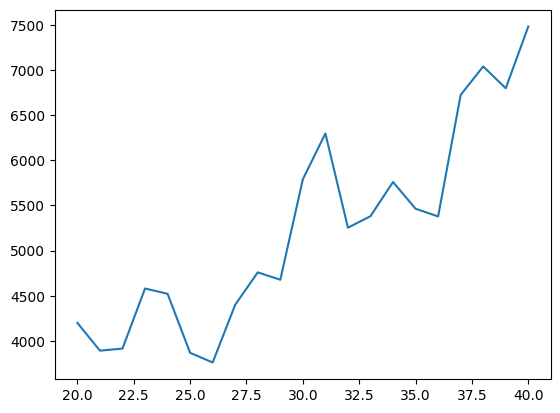

In [ ]:
sns.lineplot(x = time_step_lst, y = val_mae_lst)
plt.xlabel("Time step")
plt.ylabel("Validation MAE")

In [ ]:
tuned_time_step = time_step_lst[np.argmin(val_mae_lst)]
print(f"Minimum value is reached at {tuned_time_step} time step")

Minimum value is reached at 26 time step


In [ ]:
#Tuned hyperparameters
TIME_STEP = tuned_time_step
NUM_TREES = 1000

In [ ]:
train_val_data = np.array(list(train_data.reshape(-1)) + list(val_data.reshape(-1))).reshape(-1, 1)

In [ ]:
xgb_reg, test_preds, original_y_test = train_and_eval_xgb(num_trees = NUM_TREES,  time_step = TIME_STEP, train_data = train_val_data, val_data = test_data)

In [ ]:
print("Test data MAE: ", mean_absolute_error(original_y_test, test_preds))
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_y_test, test_preds)))
print("Test data R2 score:", r2_score(original_y_test, test_preds))

Test data MAE:  821.3159513392861
Test data R2 score: 0.8962987340215739


In [ ]:
file_name = "xgb_model.pkl"
pickle.dump(xgb_reg, open(file_name, "wb"))

In [ ]:
from google.colab import files
files.download("xgb_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def load_data(coin, currency, limit):
    data = cryptocompare.get_historical_price_day(coin, currency, limit=limit)
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    return pd.DataFrame({"date": df['time'], "close": df["close"]})

def predict(model, data, future_days, time_step):
    '''
        Input: data: numpy array
        Output: price_predictions: numpy array of shape (future_days, 1)
    '''
    price_predictions = []
    temp_prices = data[-time_step:]
    for i in range(future_days):
        if type(model) == xgb.sklearn.XGBRegressor:
            price_prediction = model.predict(temp_prices.reshape(1, -1))[0]
        else:
            price_prediction = model.predict(temp_prices.reshape(1, -1, 1))[0][0]
        price_predictions.append(price_prediction)
        temp_prices = np.append(temp_prices, price_prediction)
        temp_prices = temp_prices[1:]
    price_predictions = np.array(price_predictions).reshape(-1, 1)
    return price_predictions

def preprocess(data):
    return scaler.transform(np.array(data).reshape(-1, 1)).reshape(1, -1)[0]

def postprocess(data):
    return scaler.inverse_transform(data).reshape(1, -1)[0]

def get_future_closes(model, data, future_days, time_step):
    today = data["date"].to_list()[-1]
    future_dates = [today + datetime.timedelta(days = i) for i in range(1, future_days + 1)]
    dates =  data["date"].to_list() + future_dates
    close_price = np.empty(len(dates))
    close_price[:] = np.nan
    close_price[:len(data["close"])] = data["close"]
    predicted_close = np.empty(len(dates))
    predicted_close[:] = np.nan
    price_predictions = predict(model, preprocess(data["close"]), future_days, time_step)
    price_predictions = postprocess(price_predictions)
    predicted_close[-future_days:] = price_predictions
    predicted_close[-future_days - 1] = close_price[-future_days - 1]
    return pd.DataFrame({"date": dates, "close": close_price, "predicted_close": predicted_close})

In [ ]:
data = load_data("BTC", "USD", 200)
model = xgb_reg
future_days = 100
future_closes = get_future_closes(model, data, future_days, TIME_STEP)
names = ["Close Price", "Predicted Close Price"]
names = cycle(names)
fig = px.line(future_closes,x=future_closes['date'], y=[future_closes['close'],future_closes['predicted_close']],
        labels={'value':'Close price','date': 'Date'})

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.show()